# Format the interaction fingerprint

In [2]:
import pandas as pd
from rdkit import Chem, DataStructs
import numpy as np
from multiprocessing import Process, Queue, cpu_count
from scipy.cluster.hierarchy import ward, fcluster
import glob


In [3]:
raw_fps = pd.read_csv("./autodock_gpu_site2/col.csv")
raw_fps.head(2)

,entry,interaction,A/ALA/653,A/ALA/661,A/ASN/658,A/GLN/664,A/GLY/648,A/GLY/648;A/SER/649,A/GLY/657,A/GLY/657;A/ASN/658,...,D/SER/660.9,D/THR/623.9,D/TYR/652.9,D/TYR/652;D/ALA/653.9,D/VAL/625.9,D/VAL/644.9,D/VAL/659.4,D/VAL/659;D/SER/660,z/LIG/9999.9,Unnamed: 1042


## Get the number of unique residues involved in interaction no matter the chain

In [4]:
valid_residues = ['CYS', 'ASP', 'SER', 'GLN', 'LYS', 'ILE', 'PRO', 
                    'THR', 'PHE', 'ASN', 'GLY', 'HIS', 'LEU', 'ARG', 
                    'TRP', 'ALA', 'VAL', 'GLU', 'TYR', 'MET']

residues_per_chain = [i for i in raw_fps.columns if '/' in i]

unique_residues = list(set([f'{i.split("/")[1]}/{i.split("/")[2].split(".")[0]}' 
                    for i in residues_per_chain 
                    if i.split('/')[1] in valid_residues if ';' not in i]))

print(f'list of unique residues (chain independent): {unique_residues}')

list of unique residues (chain independent): ['GLY/657', 'LEU/646', 'MET/651', 'ILE/663', 'TYR/652', 'LEU/650', 'ASN/658', 'ILE/662', 'VAL/644', 'SER/624', 'SER/654', 'GLY/648', 'VAL/659', 'VAL/625', 'THR/623', 'ILE/642', 'ALA/661', 'ILE/647', 'MET/554', 'ALA/653', 'MET/645', 'LEU/622', 'PHE/656', 'PHE/557', 'GLN/664', 'SER/660', 'LEU/550', 'SER/621', 'ILE/655', 'SER/649', 'PHE/619']


## Builds the same number of bits per chain based on the number of unique residues

In [5]:
unique_residues_per_chain = []
for chain in ['A', 'B', 'C', 'D']:
    unique_residues_per_chain += [f'{chain}/{i}' for i in unique_residues]

print(f'list of unique residues (per chain): {unique_residues_per_chain}')

list of unique residues (per chain): ['A/GLY/657', 'A/LEU/646', 'A/MET/651', 'A/ILE/663', 'A/TYR/652', 'A/LEU/650', 'A/ASN/658', 'A/ILE/662', 'A/VAL/644', 'A/SER/624', 'A/SER/654', 'A/GLY/648', 'A/VAL/659', 'A/VAL/625', 'A/THR/623', 'A/ILE/642', 'A/ALA/661', 'A/ILE/647', 'A/MET/554', 'A/ALA/653', 'A/MET/645', 'A/LEU/622', 'A/PHE/656', 'A/PHE/557', 'A/GLN/664', 'A/SER/660', 'A/LEU/550', 'A/SER/621', 'A/ILE/655', 'A/SER/649', 'A/PHE/619', 'B/GLY/657', 'B/LEU/646', 'B/MET/651', 'B/ILE/663', 'B/TYR/652', 'B/LEU/650', 'B/ASN/658', 'B/ILE/662', 'B/VAL/644', 'B/SER/624', 'B/SER/654', 'B/GLY/648', 'B/VAL/659', 'B/VAL/625', 'B/THR/623', 'B/ILE/642', 'B/ALA/661', 'B/ILE/647', 'B/MET/554', 'B/ALA/653', 'B/MET/645', 'B/LEU/622', 'B/PHE/656', 'B/PHE/557', 'B/GLN/664', 'B/SER/660', 'B/LEU/550', 'B/SER/621', 'B/ILE/655', 'B/SER/649', 'B/PHE/619', 'C/GLY/657', 'C/LEU/646', 'C/MET/651', 'C/ILE/663', 'C/TYR/652', 'C/LEU/650', 'C/ASN/658', 'C/ILE/662', 'C/VAL/644', 'C/SER/624', 'C/SER/654', 'C/GLY/648', 

### Open each of the 10 files and concatenate them after reformating

In [6]:
ordered_columns = ['entry','interaction'] + unique_residues_per_chain

In [8]:
flag = 0
for csv in glob.glob('autodock_gpu_site2/*fp.csv'):
    df = pd.read_csv(csv)
    print(f'loading {csv} with dimension {df.shape}')
    for chain_residue in unique_residues_per_chain:
        if chain_residue not in df.columns:
            df[chain_residue] = 0
    df = df[ordered_columns]
    if flag == 0:
        raw_fps = df
        flag = 1
    else:
        raw_fps = pd.concat([raw_fps, df])

loading autodock_gpu_site2/41659-outputs-interaction_fp.csv with dimension (258478, 101)
loading autodock_gpu_site2/41660-outputs-interaction_fp.csv with dimension (255378, 129)
loading autodock_gpu_site2/41661-outputs-interaction_fp.csv with dimension (261578, 104)
loading autodock_gpu_site2/41662-outputs-interaction_fp.csv with dimension (261578, 104)
loading autodock_gpu_site2/41667-outputs-interaction_fp.csv with dimension (260958, 105)
loading autodock_gpu_site2/41658-outputs-interaction_fp.csv with dimension (255378, 102)
loading autodock_gpu_site2/41665-outputs-interaction_fp.csv with dimension (258540, 122)
loading autodock_gpu_site2/41656-outputs-interaction_fp.csv with dimension (255998, 102)
loading autodock_gpu_site2/41657-outputs-interaction_fp.csv with dimension (259098, 98)
loading autodock_gpu_site2/41663-outputs-interaction_fp.csv with dimension (261516, 93)


In [90]:
raw_fps.shape

(2578642, 111)

In [54]:
#unique_residues_per_chain = ['A/SER/624', 'A/GLY/657', 'A/TYR/652', 'A/PHE/656', 'A/SER/660', 'A/ALA/653', 
#'B/SER/624', 'B/GLY/657', 'B/TYR/652', 'B/PHE/656', 'B/SER/660', 'B/ALA/653', 
#'C/SER/624', 'C/GLY/657', 'C/TYR/652', 'C/PHE/656', 'C/SER/660', 'C/ALA/653', 
#'D/SER/624', 'D/GLY/657', 'D/TYR/652', 'D/PHE/656', 'D/SER/660', 'D/ALA/653']

#for chain_residue in unique_residues_per_chain:
#    if chain_residue not in raw_fps.columns:
#        raw_fps[chain_residue] = 0

Make sure the ordering is the same for each chain


In [55]:
#raw_fps = raw_fps[['entry','interaction','A/SER/660', 'A/SER/624', 'A/PHE/656',
#                     'A/TYR/652', 'A/ALA/653', 'A/GLY/657', 'B/SER/660', 'B/SER/624', 
#                     'B/PHE/656', 'B/TYR/652', 'B/ALA/653', 'B/GLY/657', 'C/SER/660', 
#                     'C/SER/624', 'C/PHE/656', 'C/TYR/652', 'C/ALA/653', 'C/GLY/657', 
#                     'D/SER/660', 'D/SER/624', 'D/PHE/656', 'D/TYR/652', 'D/ALA/653', 'D/GLY/657']]

Add the molecule name information

In [9]:
raw_fps['molecule'] = [f'{i.split("_")[2]}_{i.split("_")[3]}' for i in raw_fps.entry]
raw_fps.to_csv('autodock_gpu_site2_fps.csv')

In [12]:
fps_df = raw_fps.pivot(index=['entry','molecule'], columns='interaction')
fps_df

A/SER/621  \
interaction                             Amide-aromatic stacking   
entry                          molecule                           
receptor_noK_2001_0_Run_1.pdb  2001_0                         0   
receptor_noK_2001_0_Run_10.pdb 2001_0                         0   
receptor_noK_2001_0_Run_11.pdb 2001_0                         0   
receptor_noK_2001_0_Run_12.pdb 2001_0                         0   
receptor_noK_2001_0_Run_13.pdb 2001_0                         0   
...                                                         ...   
receptor_noK_9_0_Run_5.pdb     9_0                            0   
receptor_noK_9_0_Run_6.pdb     9_0                            0   
receptor_noK_9_0_Run_7.pdb     9_0                            0   
receptor_noK_9_0_Run_8.pdb     9_0                            0   
receptor_noK_9_0_Run_9.pdb     9_0                            0   

                                                            \
interaction                             Anion-electrophile   
entry                          molecule                      
receptor_noK_2001_0_Run_1.pdb  2001_0                    0   
receptor_noK_2001_0_Run_10.pdb 2001_0                    0   
receptor_noK_2001_0_Run_11.pdb 2001_0                    0   
receptor_noK_2001_0_Run_12.pdb 2001_0                    0   
receptor_noK_2001_0_Run_13.pdb 2001_0                    0   
...                                                    ...   
receptor_noK_9_0_Run_5.pdb     9_0                       0   
receptor_noK_9_0_Run_6.pdb     9_0                       0   
receptor_noK_9_0_Run_7.pdb     9_0                       0   
receptor_noK_9_0_Run_8.pdb     9_0                       0   
receptor_noK_9_0_Run_9.pdb     9_0                       0   

                                                                              \
interaction                             Antiparallel multipolar Atom overlap   
entry                          molecule                                        
receptor_noK_2001_0_Run_1.pdb  2001_0                         0            0   
receptor_noK_2001_0_Run_10.pdb 2001_0                         0            0   
receptor_noK_2001_0_Run_11.pdb 2001_0                         0            0   
receptor_noK_2001_0_Run_12.pdb 2001_0                         0            0   
receptor_noK_2001_0_Run_13.pdb 2001_0                         0            0   
...                                                         ...          ...   
receptor_noK_9_0_Run_5.pdb     9_0                            0            0   
receptor_noK_9_0_Run_6.pdb     9_0                            0            0   
receptor_noK_9_0_Run_7.pdb     9_0                            0            0   
receptor_noK_9_0_Run_8.pdb     9_0                            0            0   
receptor_noK_9_0_Run_9.pdb     9_0                            0            0   

                                                                      \
interaction                             Cation-nucleophile Cation-pi   
entry                          molecule                                
receptor_noK_2001_0_Run_1.pdb  2001_0                    0         0   
receptor_noK_2001_0_Run_10.pdb 2001_0                    0         0   
receptor_noK_2001_0_Run_11.pdb 2001_0                    0         0   
receptor_noK_2001_0_Run_12.pdb 2001_0                    0         0   
receptor_noK_2001_0_Run_13.pdb 2001_0                    0         0   
...                                                    ...       ...   
receptor_noK_9_0_Run_5.pdb     9_0                       0         0   
receptor_noK_9_0_Run_6.pdb     9_0                       0         0   
receptor_noK_9_0_Run_7.pdb     9_0                       0         0   
receptor_noK_9_0_Run_8.pdb     9_0                       0         0   
receptor_noK_9_0_Run_9.pdb     9_0                       0         0   

                                                                     \
interaction                             Chalc

In [91]:
import random 
subset = list(set(raw_fps['molecule']))
random.shuffle(subset)
subset = subset[:100]

In [29]:
#fps_df.to_csv('autodock_gpu_large_site_fps.csv')

In [68]:
#retained_interactions = ['Displaced face-to-face pi-stacking', 'Displaced face-to-edge pi-stacking',
#                        'Tilted multipolar', 'Unfavorable nucleophile-nucleophile', 'Orthogonal multipolar',
#                        'Unfavorable electrophile-electrophile', 'Displaced face-to-slope pi-stacking', 
#                        'Face-to-edge pi-stacking', 'Face-to-slope pi-stacking', 'Hydrogen bond', 'Atom overlap', 
#                        'Hydrophobic','Cation-nucleophile', 'Weak hydrogen bond', 'Unfavorable cation-electrophile',
#                        'Van der Waals clash', 'Van der Waals', 'Cation-pi']

retained_interactions = ['Displaced face-to-face pi-stacking', 'Displaced face-to-edge pi-stacking',
                        'Tilted multipolar', 'Unfavorable nucleophile-nucleophile', 'Orthogonal multipolar',
                        'Unfavorable electrophile-electrophile', 'Displaced face-to-slope pi-stacking', 
                        'Face-to-edge pi-stacking', 'Face-to-slope pi-stacking', 'Hydrogen bond', 
                        'Hydrophobic','Cation-nucleophile', 'Weak hydrogen bond', 'Unfavorable cation-electrophile',
                        'Van der Waals', 'Cation-pi']

## Compute tanimoto coefficient

In [47]:
def tanimoto(vector1, vector2):
    """ function to calculate the taniomoto similarity of two binary vectors of the same length. only on-bits are
    considered. The formula used is:
    .. math::
            S = c / (a + b - c)
            a = on-bits in vector1
            b = on-bits in vector2
            c = on-bits in both vectors
    :param vector1: {numpy.ndarray or list} first binary vector
    :param vector2: {numpy.ndarray or list} second binary vector
    :return: tanimoto similarity
    """
    tc = 0
    a = np.where(vector1 >= 1)[0]
    for i in range(0, len(vector1), int(len(vector1)/4)):
        b = np.where(np.concatenate((vector2[i:],vector2[:i]), axis=None) >= 1)[0]
        if len(np.intersect1d(a, b)) / (float(len(a) + len(b)) - len(np.intersect1d(a, b))) > tc:
            tc = len(np.intersect1d(a, b)) / (float(len(a) + len(b)) - len(np.intersect1d(a, b)))
    return 1-tc


def list2batches(lst, n):
    """Divide a list into n batches
    :param lst: {list}
    :param n: {int}
    :return: list of n lists
    """
    p = len(lst) // n
    if len(lst) - p > 0:
        return [lst[:p]] + list2batches(lst[p:], n - 1)
    else:
        return [lst]


def _batch_vs_all(batch, fps, q, mtrc):
    """Function to calculate pairwise similarities from a batch of fingerprints to all fingerprints in a set of molecules
    :param batch: {list} list of RDKit fingerprints, a subset of ``fps``
    :param fps: {list} list of RDKit fingerprints of all molecules
    :param q: {multiprocessing queue} queue for multiprocessing
    :return: {list} pairwise similarities batch-to-fps as the Tanimoto distance
    """
    q.put(np.asarray([[tanimoto(fp1, fp2) for fp2 in fps] for fp1 in batch]))


def parallel_pairwise_similarities(fps, fps2=None, metric='tanimoto'):
    """Function for parallel pairwise similarity calculation of RDKit-type fingerprints
    :param fps: {list} list of fingerprints (or numpy array) to calculate pairwise similarities for
    :param fps2: {list} list of fingerprints to calculate pairwise similarities to fps; if None, only pairwise
        similarities of all fingerprints in fps are calculated.
    :param metric: {str} available for RDKit fingerprints: tanimoto, available for numpy: tanimoto, cosine, euclidean
    :return: {numpy.ndarray} array of Tanimoto similarities
    """
    if not (isinstance(fps2, np.ndarray) or isinstance(fps2, list)):
        fps2 = fps
    if len(fps.shape) == 1:
        fps = fps.reshape(1, -1)
    if len(fps) < int(
            10 * cpu_count()):  # if only small array, don't parallelize and calculate all internal similarities
        rslt = np.array([list(map(lambda x: tanimoto(fp, x), fps)) for fp in fps2]).reshape(
            (len(fps), len(fps2)))
    else:
        queue = Queue()
        rslt = []
        for batch in list2batches(fps, cpu_count()):
            p = Process(target=_batch_vs_all, args=(batch, fps2, queue, metric,))
            p.start()
        for _ in range(cpu_count()):
            rslt.extend(queue.get())

    
    return np.array(rslt).astype('float')

def hierarchical_clustering(fps, t=0.1):
    triu = np.triu(parallel_pairwise_similarities(fps))
    iu1 = np.triu_indices(fps.shape[0], k=1)

    return fcluster(ward(triu[iu1]), t=t, criterion='distance')

def hierarchical_clustering_np(np_array, t=0.1):
    triu = np.triu(np_array)
    iu1 = np.triu_indices(np_array.shape[0], k=1)

    return fcluster(ward(triu[iu1]), t=t, criterion='distance')



### check tanimoto comparison

In [70]:
entries = {i[0]:j for j,i in enumerate(fps_df.index)}


In [ ]:
fps_np = fps_df.to_numpy()
tanimoto(fps_np[entries['4_0_0_04'],:], fps_np[entries['6_0_0_06'],:])

In [72]:
testList = ['0_0_04', '0_0_06']
df_test = fps_df.query("entry == @testList")
df_test_diff = df_test.loc[:, (df_test != 0).any(axis=0)]
df_test_diff.to_csv('diff_poses_4_6_of0_0.csv')


## Compute the fingerprint similarity per molecule

Keep one representant per cluster

In [92]:
df_subset = fps_df.query("molecule == @subset")

molecules = list(set([x[1] for x in df_subset.index]))

In [96]:
retained_poses = []
for mol in molecules:
    df_mol = fps_df.query(f'molecule == "{mol}"')
    hclust = hierarchical_clustering(df_mol.to_numpy(), t=.0)
    idx = np.unique(hclust, return_index=True)[1]
    retained_poses += [df_mol.index[x][0] for x in idx]
hclust

array([ 5, 16,  1,  9,  3,  4, 14,  7, 20, 18,  6, 10,  2, 12, 19, 13, 15,
        8, 17, 11], dtype=int32)

In [97]:
print(f'retained poses: {len(retained_poses)}/{df_subset.shape[0]}')

retained poses: 1907/2000


Consider only unique poses

In [98]:
fps_unique = fps_df.query("entry == @retained_poses")


Run it on the remaining data

In [99]:
distmat = parallel_pairwise_similarities(fps_unique.to_numpy())


In [100]:
a = hierarchical_clustering_np(distmat, t=0.7)

In [101]:
df = pd.DataFrame(a, columns=['cluster'])
df['nb'] = 1
df.groupby('cluster').sum().reset_index().sort_values('nb')

,cluster,nb
74,75,1
89,90,1
687,688,1
439,440,1
477,478,1
...,...,...
574,575,10
498,499,11
502,503,14
566,567,16


In [102]:
len(set(df.cluster))

703

In [103]:
fps_unique['cluster'] = a

/tmp/ipykernel_31336/1139377806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fps_unique['cluster'] = a


In [108]:
fps_unique.reset_index()[['molecule', 'cluster']].drop_duplicates().groupby('cluster').count().sort_values('molecule')


/tmp/ipykernel_31336/1993557191.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  fps_unique.reset_index()[['molecule', 'cluster']].drop_duplicates().groupby('cluster').count().sort_values('molecule')


,molecule
interaction,
cluster,
92,1
547,1
548,1
45,1
478,1
...,...
96,4
458,4


In [118]:
triu = np.triu(distmat)
iu1 = np.triu_indices(distmat.shape[0], k=1)

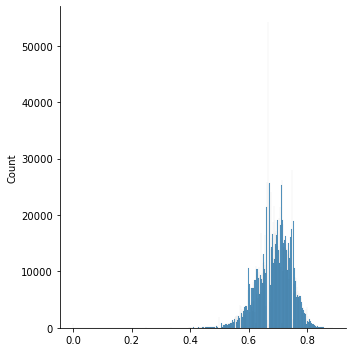

In [119]:
import seaborn as sns

sns.displot(triu[iu1])